## IQR

The interquartile range rule is useful in detecting the presence of outliers.
Outliers are individual values that fall outside of the overall pattern of the rest of the data. The interquartile
range can be used to help detect outliers. The steps in calculating interquartile range are
1. Calculate the interquartile range for our data
2. Multiply the interquartile range (IQR) by the number 1.5
3. Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier.
4. Subtract 1.5 x (IQR) from the first quartile. Any number less than this is a suspected outlier.

# SMOTE

In [1]:
! pip install imblearn
! pip install scikit-plot

import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from pprint import pprint
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.metrics import classification_report, precision_recall_curve, roc_curve, roc_auc_score 
import scikitplot as skplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('../assets/creditcard.csv')

In [3]:
# Scale columns 'Amount' and 'Time'
std_scaler = StandardScaler()

df['amount_scaled'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['time_scaled'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   V1             284807 non-null  float64
 1   V2             284807 non-null  float64
 2   V3             284807 non-null  float64
 3   V4             284807 non-null  float64
 4   V5             284807 non-null  float64
 5   V6             284807 non-null  float64
 6   V7             284807 non-null  float64
 7   V8             284807 non-null  float64
 8   V9             284807 non-null  float64
 9   V10            284807 non-null  float64
 10  V11            284807 non-null  float64
 11  V12            284807 non-null  float64
 12  V13            284807 non-null  float64
 13  V14            284807 non-null  float64
 14  V15            284807 non-null  float64
 15  V16            284807 non-null  float64
 16  V17            284807 non-null  float64
 17  V18            284807 non-nul

### Splitting testing and training data

In [4]:
X = df.drop('Class',axis=1) # independent columns - features
y = df.loc[:,'Class']       # target column - Class

In [5]:
print("Input Shape : ", X.shape)
print("Output Shape : ", y.shape)

Input Shape :  (284807, 30)
Output Shape :  (284807,)


In [6]:
#Train test split into train and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [7]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(227845, 30) (56962, 30) (227845,) (56962,)


## Model 1: Baseline Logistic Regression Model

In [8]:
# Create baseline logistic regression classifier
lr = LogisticRegression()

# Fit training data and training labels
lr.fit(X_train, y_train)

LogisticRegression()

### Baseline score

In [9]:
print(f'Training accuracy: {lr.score(X_train, y_train)}')
print(f'Testing accuracy: {lr.score(X_test, y_test)}')

Training accuracy: 0.9992319339902126
Testing accuracy: 0.9991222218320986


##  Increase successful detections with data resampling

### SMOTE to The Rescue

In [10]:
# Define resampling method and split into train and test
sm = SMOTE(sampling_strategy='minority', random_state=1, k_neighbors=5)

In [11]:
# Apply resampling to the training data only
X_train_res, y_train_res = sm.fit_sample(df.drop('Class', axis=1), df['Class'])

In [15]:
print(X_train_res.shape ,y_train_res.shape)

(568630, 30) (568630,)


In [16]:
new_df = pd.concat([pd.DataFrame(X_train_res), pd.DataFrame(y_train_res)], axis=1)
new_df['Class'].value_counts()

1    284315
0    284315
Name: Class, dtype: int64

### Correlation Matrix with Heat Map

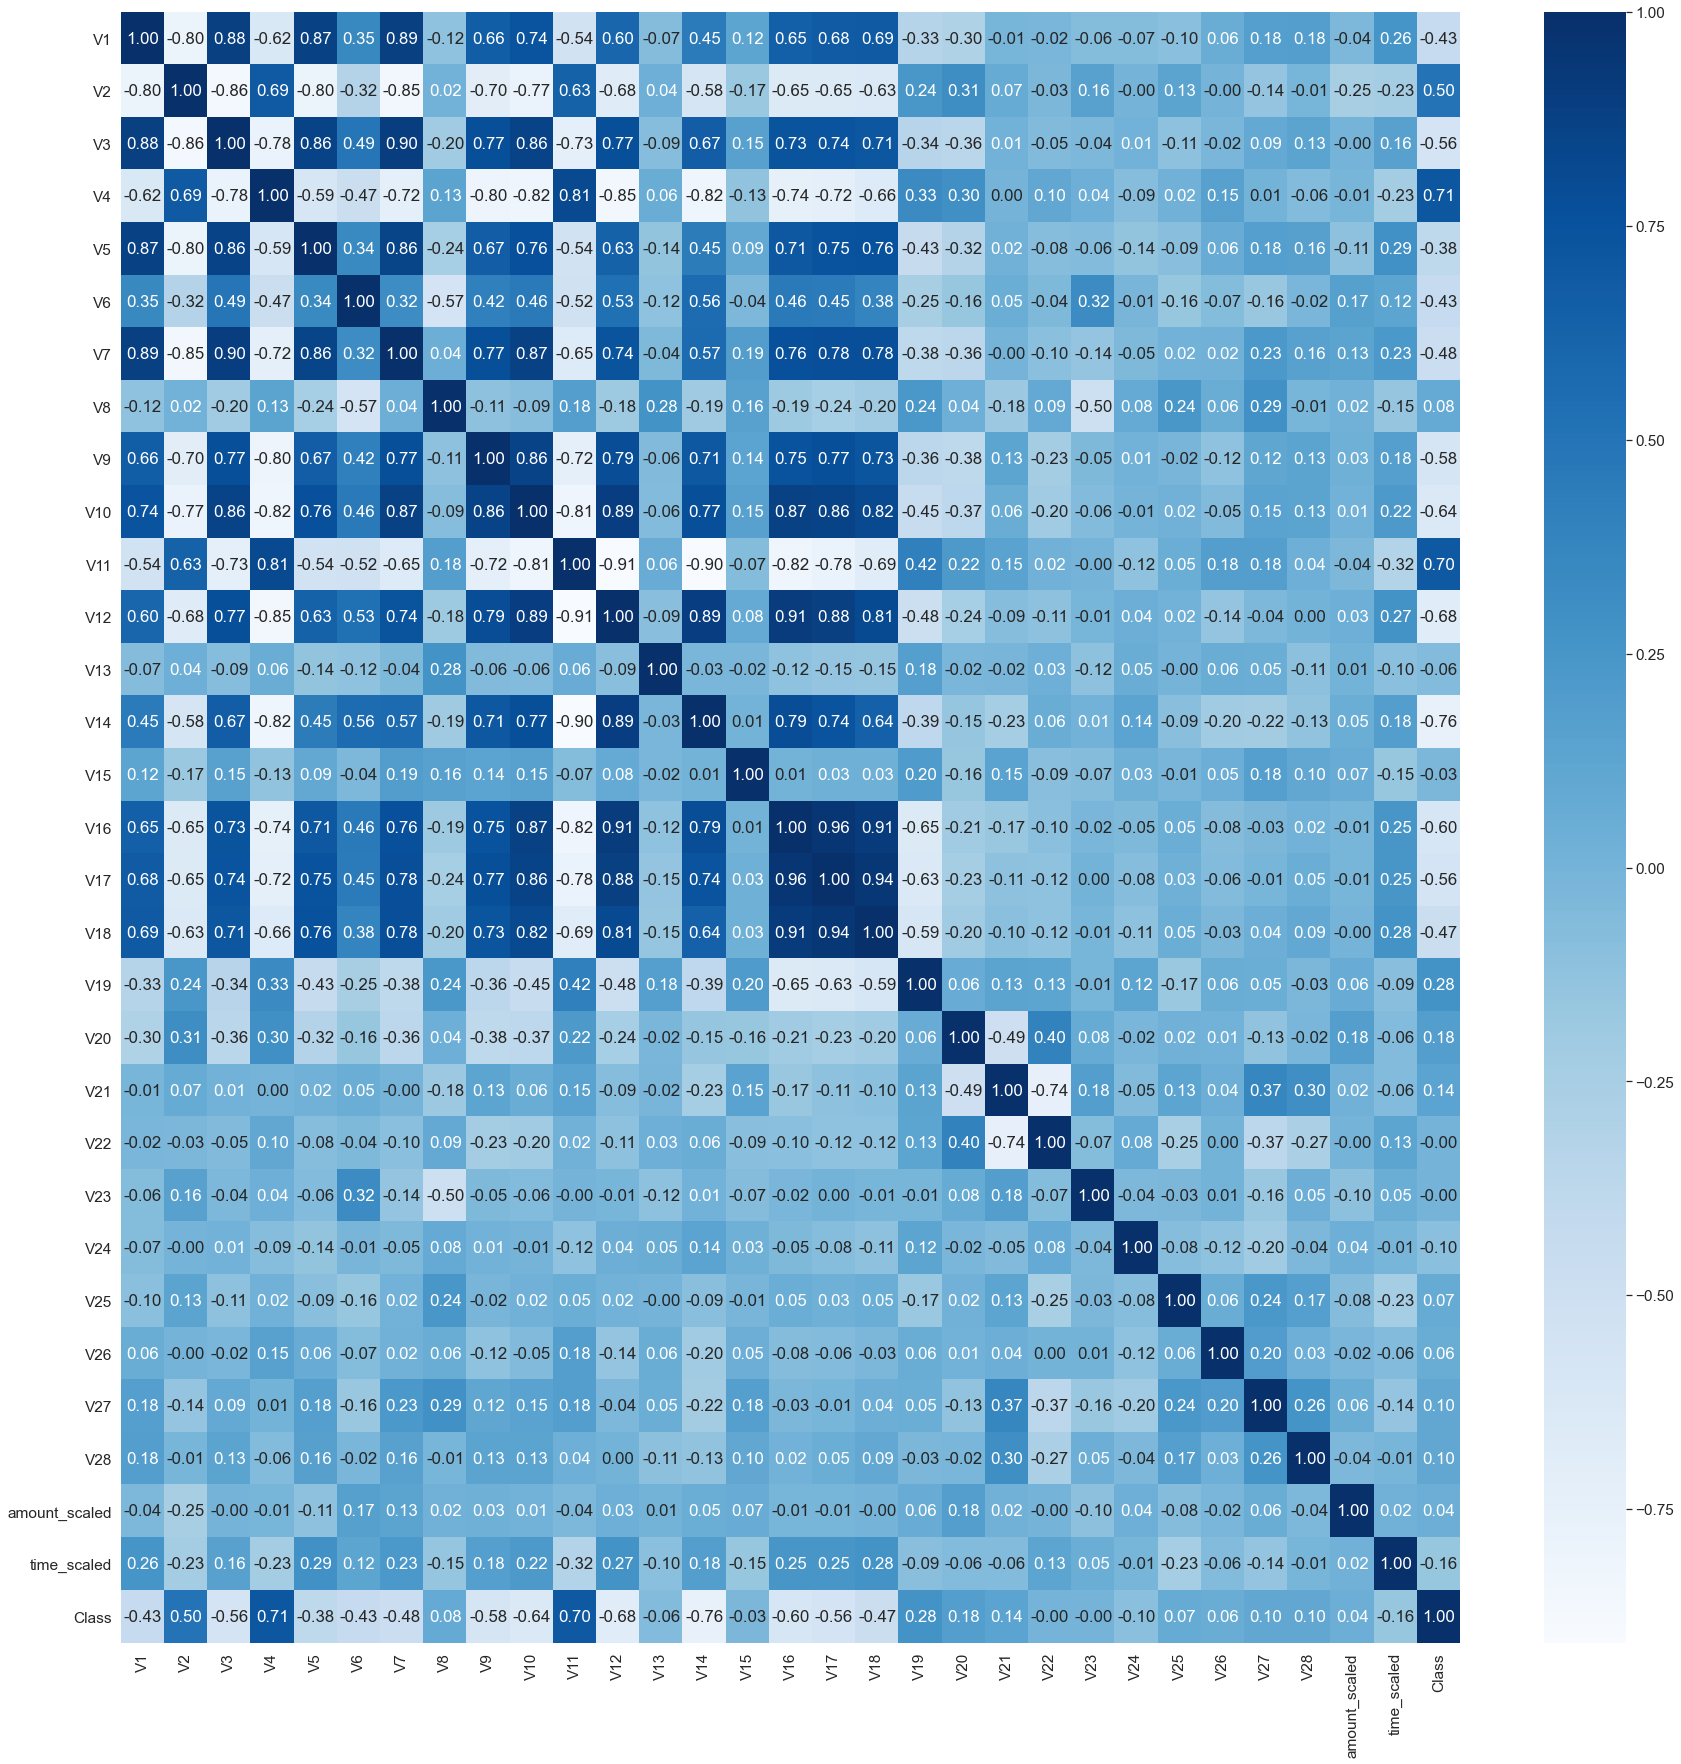

In [17]:
# Obtain correlations of each features in dataset
sns.set(font_scale=1.4)
corrmat = new_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(30,30))

# Plot heat map
correlation = sns.heatmap(new_df[top_corr_features].corr(),annot=True,fmt=".2f",cmap='Blues')


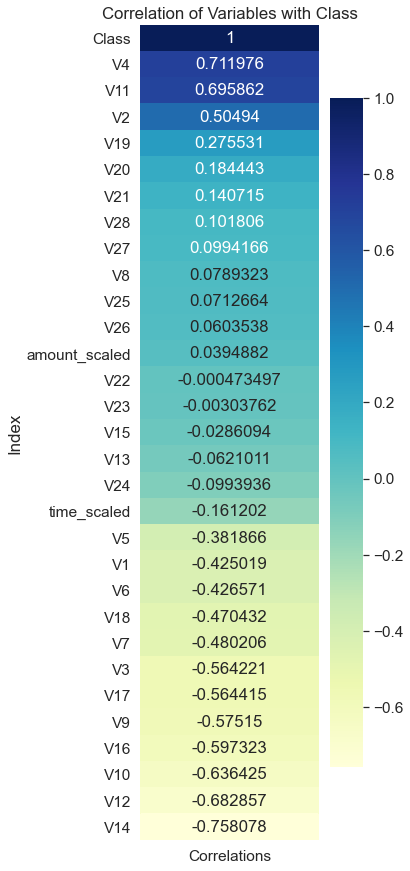

In [18]:
corr = new_df.corrwith(new_df['Class']).reset_index()
corr.columns = ['Index','Correlations']
corr = corr.set_index('Index')
corr = corr.sort_values(by=['Correlations'], ascending = False)
plt.figure(figsize=(4,15))
fig = sns.heatmap(corr, annot=True, fmt="g", cmap='YlGnBu')
plt.title("Correlation of Variables with Class")
plt.show()

For each of the top 4 highest positive and negative correlations, we would create box plots to helps us visualize the extent of outliers.

### Box Plots

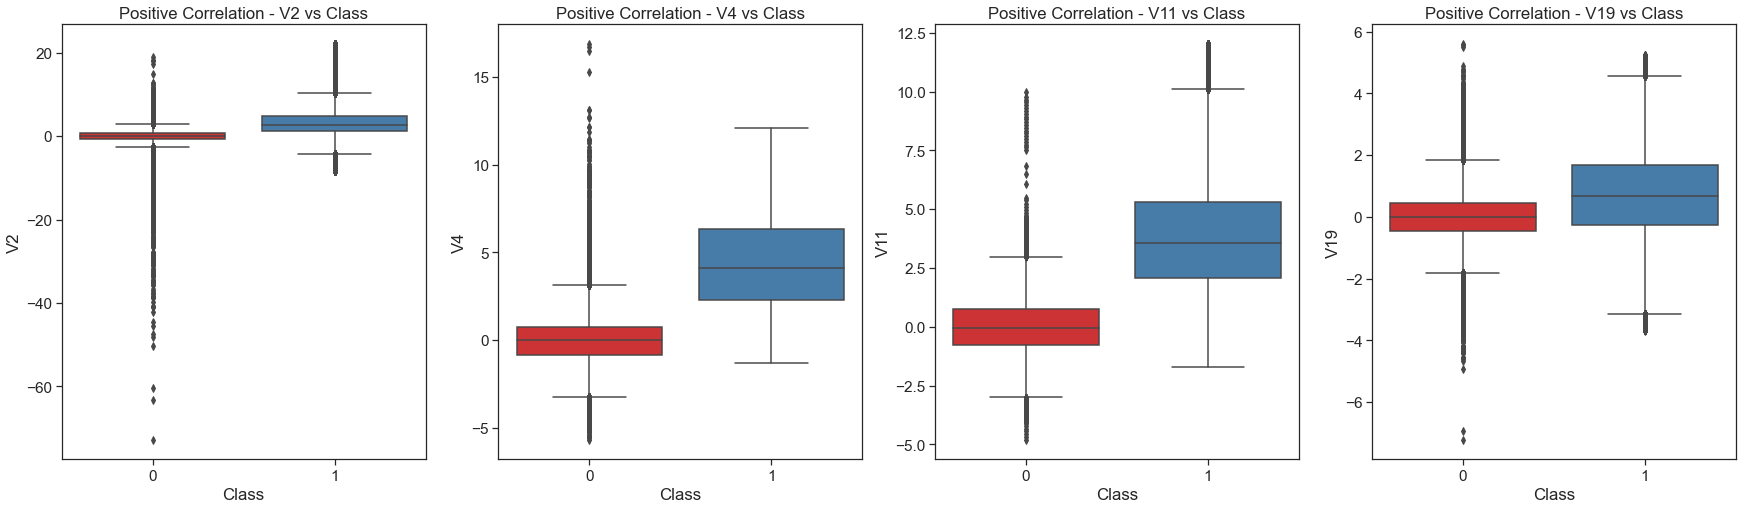

In [19]:
sns.set_style('ticks')
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V4', data=new_df, palette='Set1', ax=axes[1])
axes[1].set_title('Positive Correlation - V4 vs Class')

sns.boxplot(x='Class', y='V11', data=new_df, palette='Set1', ax=axes[2])
axes[2].set_title('Positive Correlation - V11 vs Class')

sns.boxplot(x='Class', y='V2', data=new_df, palette='Set1', ax=axes[0])
axes[0].set_title('Positive Correlation - V2 vs Class')

sns.boxplot(x='Class', y='V19', data=new_df, palette='Set1', ax=axes[3])
axes[3].set_title('Positive Correlation - V19 vs Class')

plt.show()

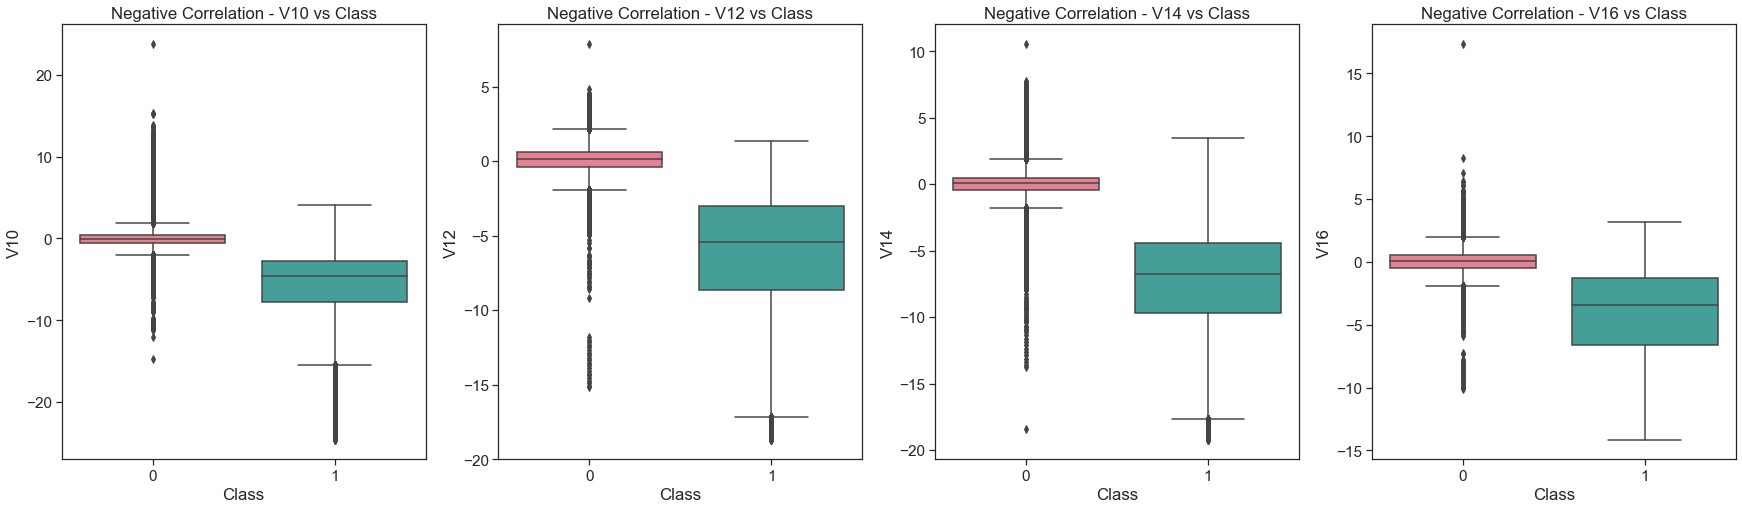

In [21]:
f, axes = plt.subplots(ncols=4, figsize=(30,8))

sns.boxplot(x='Class', y='V16', data=new_df, palette='husl', ax=axes[3])
axes[3].set_title('Negative Correlation - V16 vs Class')

sns.boxplot(x='Class', y='V10', data=new_df, palette='husl', ax=axes[0])
axes[0].set_title('Negative Correlation - V10 vs Class')

sns.boxplot(x='Class', y='V12', data=new_df, palette='husl', ax=axes[1])
axes[1].set_title('Negative Correlation - V12 vs Class')

sns.boxplot(x='Class', y='V14', data=new_df, palette='husl', ax=axes[2])
axes[2].set_title('Negative Correlation - V14 vs Class')


plt.show()

### Distribution Plot

Top 4 Features - Positive Correlation with Class



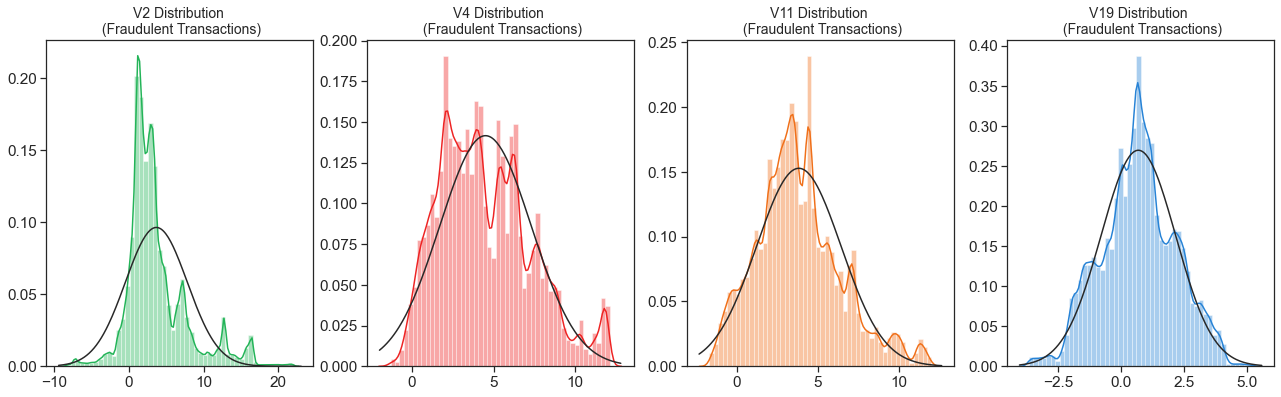

In [22]:
print('Top 4 Features - Positive Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v4_fraud_dist = new_df['V4'].loc[new_df['Class'] == 1].values
sns.distplot(v4_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V4 Distribution \n (Fraudulent Transactions)', fontsize=14)

v11_fraud_dist = new_df['V11'].loc[new_df['Class'] == 1].values
sns.distplot(v11_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V11 Distribution \n (Fraudulent Transactions)', fontsize=14)

v2_fraud_dist = new_df['V2'].loc[new_df['Class'] == 1].values
sns.distplot(v2_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V2 Distribution \n (Fraudulent Transactions)', fontsize=14)

v19_fraud_dist = new_df['V19'].loc[new_df['Class'] == 1].values
sns.distplot(v19_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V19 Distribution \n (Fraudulent Transactions)', fontsize=14)

plt.show()

Top 4 Features - Negative Correlation with Class



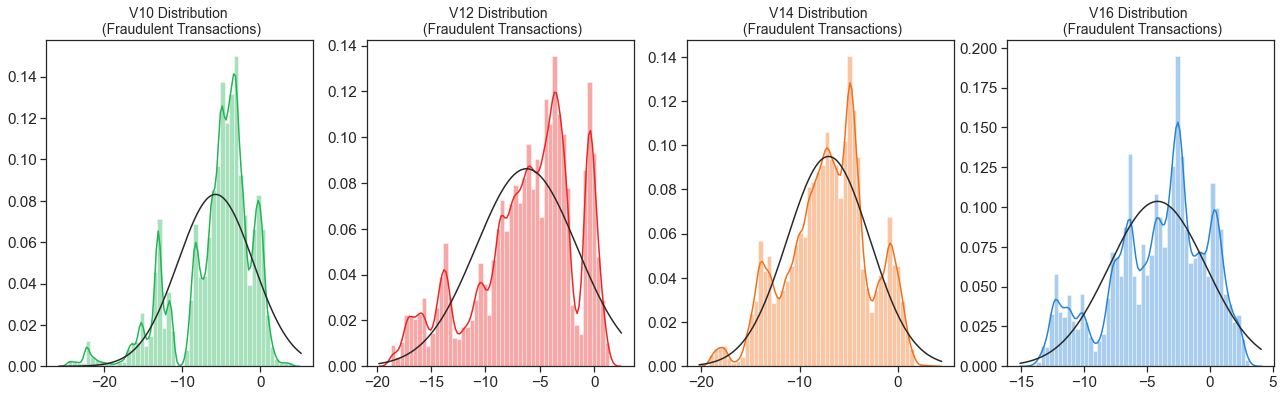

In [23]:
print('Top 4 Features - Negative Correlation with Class\n')
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(22, 6))

v16_fraud_dist = new_df['V16'].loc[new_df['Class'] == 1].values
sns.distplot(v16_fraud_dist, ax=ax4, fit=norm, color='#2783d6')
ax4.set_title('V16 Distribution \n (Fraudulent Transactions)', fontsize=14)

v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist, ax=ax1, fit=norm, color='#23b458')
ax1.set_title('V10 Distribution \n (Fraudulent Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist, ax=ax2, fit=norm, color='#ee2424')
ax2.set_title('V12 Distribution \n (Fraudulent Transactions)', fontsize=14)

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist, ax=ax3, fit=norm, color='#f0701a')
ax3.set_title('V14 Distribution \n (Fraudulent Transactions)', fontsize=14)


plt.show()

### Removal of Extreme Outliers

In order to obtain a good model performance, there is a need to identify and remove extreme outliers from features that have a high correlation with our classes. This clean-up process helps to ensure that the observations best represent the problem.

One of the techniques is to use the Interquartile Range Method (IQR).

The threshold for removing outliers has been determined at 1.5 to prevent the risk of information loss, which will cause the models to have a lower accuracy (ie. under-fitting).

In [24]:
print('Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class\n')


# V4 - Removing extreme outliers from fraudulent transactions
print('V4 Analysis')
v4_fraud = new_df['V4'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v4_fraud, 25), np.percentile(v4_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v4_iqr = q75 - q25
print('IQR: {}'.format(v4_iqr))

v4_cut_off = v4_iqr * 1.5
v4_lower, v4_upper = q25 - v4_cut_off, q75 + v4_cut_off
print('Cut-Off: {}'.format(v4_cut_off))
print('Lower Limit: {}'.format(v4_lower))
print('Upper Limit: {}'.format(v4_upper))

outliers = [x for x in v4_fraud if x < v4_lower or x > v4_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V4'] > v4_upper) | (new_df['V4'] < v4_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V11 - Removing extreme outliers from fraudulent transactions
print('V11 Analysis')
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('IQR: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut-Off: {}'.format(v11_cut_off))
print('Lower Limit: {}'.format(v11_lower))
print('Upper Limit: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V11'] > v11_upper) | (new_df['V11'] < v11_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V2 - Removing extreme outliers from fraudulent transactions
print('V2 Analysis')
v2_fraud = new_df['V2'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v2_fraud, 25), np.percentile(v2_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v2_iqr = q75 - q25
print('IQR: {}'.format(v2_iqr))

v2_cut_off = v2_iqr * 1.5
v2_lower, v2_upper = q25 - v2_cut_off, q75 + v2_cut_off
print('Cut-Off: {}'.format(v2_cut_off))
print('Lower Limit: {}'.format(v2_lower))
print('Upper Limit: {}'.format(v2_upper))

outliers = [x for x in v2_fraud if x < v2_lower or x > v2_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V2'] > v2_upper) | (new_df['V2'] < v2_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V19 - Removing extreme outliers from fraudulent transactions
print('V19 Analysis')
v19_fraud = new_df['V19'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v19_fraud, 25), np.percentile(v19_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v19_iqr = q75 - q25
print('IQR: {}'.format(v19_iqr))

v19_cut_off = v19_iqr * 1.5
v19_lower, v19_upper = q25 - v19_cut_off, q75 + v19_cut_off
print('Cut-Off: {}'.format(v19_cut_off))
print('Lower Limit: {}'.format(v19_lower))
print('Upper Limit: {}'.format(v19_upper))

outliers = [x for x in v19_fraud if x < v19_lower or x > v19_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V19'] > v19_upper) | (new_df['V19'] < v19_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))

Removal of Extreme Outliers from Top 4 Features which are Positively Correlated with Class

V4 Analysis
25th Quartile: 2.2704057141640512 | 75th Quartile: 6.309265326898089
IQR: 4.038859612734038
Cut-Off: 6.058289419101057
Lower Limit: -3.787883704937006
Upper Limit: 12.367554745999147
Number of Outliers: 0
Number of Instances after Removing Outliers: 567941


V11 Analysis
25th Quartile: 2.0816158253470034 | 75th Quartile: 5.295746215144156
IQR: 3.2141303897971527
Cut-Off: 4.8211955846957295
Lower Limit: -2.739579759348726
Upper Limit: 10.116941799839886
Number of Outliers: 6288
Number of Instances after Removing Outliers: 561369


V2 Analysis
25th Quartile: 1.2219144018880757 | 75th Quartile: 4.698444199682713
IQR: 3.4765297977946377
Cut-Off: 5.214794696691957
Lower Limit: -3.9928802948038813
Upper Limit: 9.91323889637467
Number of Outliers: 28625
Number of Instances after Removing Outliers: 528376


V19 Analysis
25th Quartile: -0.3318563521675167 | 75th Quartile: 1.8059734878453222
I

In [25]:
print('Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class\n')

# V16 - Removing extreme outliers from fraudulent transactions
print('V16 Analysis')
v16_fraud = new_df['V16'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v16_fraud, 25), np.percentile(v16_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v16_iqr = q75 - q25
print('IQR: {}'.format(v16_iqr))

v16_cut_off = v16_iqr * 1.5
v16_lower, v16_upper = q25 - v16_cut_off, q75 + v16_cut_off
print('Cut-Off: {}'.format(v16_cut_off))
print('Lower Limit: {}'.format(v16_lower))
print('Upper Limit: {}'.format(v16_upper))

outliers = [x for x in v16_fraud if x < v16_lower or x > v16_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V16'] > v16_upper) | (new_df['V16'] < v16_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V10 - Removing extreme outliers from fraudulent transactions
print('V10 Analysis')
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v10_iqr = q75 - q25
print('IQR: {}'.format(v10_iqr))

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('Cut-Off: {}'.format(v10_cut_off))
print('Lower Limit: {}'.format(v10_lower))
print('Upper Limit: {}'.format(v10_upper))

outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V12 - Removing extreme outliers from fraudulent transactions
print('V12 Analysis')
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v12_iqr = q75 - q25
print('IQR: {}'.format(v12_iqr))

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('Cut-Off: {}'.format(v12_cut_off))
print('Lower Limit: {}'.format(v12_lower))
print('Upper Limit: {}'.format(v12_upper))

outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))
print('\n')

# V14 - Removing extreme outliers from fraudulent transactions
print('V14 Analysis')
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('25th Quartile: {} | 75th Quartile: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('IQR: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut-Off: {}'.format(v14_cut_off))
print('Lower Limit: {}'.format(v14_lower))
print('Upper Limit: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Number of Outliers: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after Removing Outliers: {}'.format(len(new_df)))


Removal of Extreme Outliers from Top 4 Features which are Negatively Correlated with Class

V16 Analysis
25th Quartile: -6.046125581543777 | 75th Quartile: -0.908300849924945
IQR: 5.1378247316188315
Cut-Off: 7.706737097428247
Lower Limit: -13.752862678972024
Upper Limit: 6.798436247503302
Number of Outliers: 101
Number of Instances after Removing Outliers: 527595


V10 Analysis
25th Quartile: -6.327011866166908 | 75th Quartile: -2.403013253712345
IQR: 3.9239986124545627
Cut-Off: 5.885997918681844
Lower Limit: -12.21300978484875
Upper Limit: 3.482984664969499
Number of Outliers: 26850
Number of Instances after Removing Outliers: 498366


V12 Analysis
25th Quartile: -6.98346589557016 | 75th Quartile: -2.5527963431874334
IQR: 4.430669552382726
Cut-Off: 6.646004328574089
Lower Limit: -13.62947022414425
Upper Limit: 4.093207985386655
Number of Outliers: 5666
Number of Instances after Removing Outliers: 492681


V14 Analysis
25th Quartile: -8.398788090043581 | 75th Quartile: -3.9278088743907

In [26]:
new_df.shape

(491941, 31)

In [27]:
new_df['Class'].value_counts()

0    275857
1    216084
Name: Class, dtype: int64

In [28]:
X_clean = new_df.iloc[:,0:30] # independent columns - features
y_clean = new_df.iloc[:,30]   # target column - Class

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean,
                                                                            test_size = 0.2,
                                                                            random_state = 1)

## Model 2: Optimized Logistic Regression Model

The logistic regression model is optimized through Grid search, an exhaustive search over specified parameter values for an estimator. It selects combinations of hyperparameters from a grid, evaluates them using cross-validation on the training data, and returns the values that perform the best.

In [29]:
# Set the model parameters for grid search
lr_param = {'penalty': ['l1', 'l2'], 
                  'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

# Set up grid search meta-estimator
grid_search = GridSearchCV(LogisticRegression(), lr_param, 
                           n_jobs=-1, scoring='roc_auc', cv=3)

# Train the grid search meta-estimator to obtain optimal model
opt_lr = grid_search.fit(X_train_clean, y_train_clean)

# Print optimal hyperparameters
pprint(opt_lr.best_estimator_.get_params())

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}


### Use the Best Model to Optimize Logistic Regression

In [30]:
print(f'Optimized Logistic Regression Model Accuracy for train data: {opt_lr.score(X_train_clean, y_train_clean)}')
print(f'Optimized Logistic Regression Model Accuracy for test data: {opt_lr.score(X_test_clean, y_test_clean)}')

Optimized Logistic Regression Model Accuracy for train data: 0.9875323014374728
Optimized Logistic Regression Model Accuracy for test data: 0.9878184330787317


Although the performance achieved by the optimized model was slightly below that of the baseline model, it represented a more realistic fit of learning curve instead of an almost perfect 100% accuracy hit for both the training and test data.

## Model 3: Naïve Bayes Model

In [31]:
# Create Naive Bayes classifier
nb = BernoulliNB()

# Fit training data and training labels
nb.fit(X_train_clean, y_train_clean)

BernoulliNB()

In [32]:
print(f'Naive Bayes Model Accuracy for train data: {nb.score(X_train_clean, y_train_clean)}')
print(f'Naive Bayes Model Accuracy for test data: {nb.score(X_test_clean, y_test_clean)}')


Naive Bayes Model Accuracy for train data: 0.9028768752286864
Naive Bayes Model Accuracy for test data: 0.9037900578316682


As compared to the optimized logistic regression model, it appears that the naïve bayes model has a less ideal fit of the learning curve with a lower accuracy rate achieved by using the trained model on the test data.

## Performance Evaluation of Models

In [33]:
# Predict target variables (ie. labels) for each classifer
lr_classifier_name = ['Baseline Logistic Regression']
lr_predicted_labels = lr.predict(X_test)

opt_lr_classifier_name = ['Optimized Logistic Regression']
opt_lr_predicted_labels = opt_lr.predict(X_test_clean)

nb_classifier_name = ['Naive Bayes']
nb_predicted_labels = nb.predict(X_test_clean)

#### 1. Classification Report

In [34]:

print("Classification Report for", lr_classifier_name, " :\n ",
      metrics.classification_report(y_test, lr_predicted_labels, 
                                    target_names=['Non-Fraudulent','Fraud']))

print("Classification Report for ", opt_lr_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, opt_lr_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

print("Classification Report for ", nb_classifier_name, " :\n ",
      metrics.classification_report(y_test_clean, nb_predicted_labels,
                                   target_names=['Non-Fraudulent','Fraud']))

Classification Report for ['Baseline Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       1.00      1.00      1.00     56864
         Fraud       0.86      0.58      0.70        98

      accuracy                           1.00     56962
     macro avg       0.93      0.79      0.85     56962
  weighted avg       1.00      1.00      1.00     56962

Classification Report for  ['Optimized Logistic Regression']  :
                  precision    recall  f1-score   support

Non-Fraudulent       0.93      0.97      0.95     55300
         Fraud       0.97      0.90      0.93     43089

      accuracy                           0.94     98389
     macro avg       0.95      0.94      0.94     98389
  weighted avg       0.94      0.94      0.94     98389

Classification Report for  ['Naive Bayes']  :
                  precision    recall  f1-score   support

Non-Fraudulent       0.86      0.99      0.92     55300
         Fraud       0.98      

In general, the optimized logistic regression model has performed well in the above metrics. In particular, with SMOTE performed to maintain a balanced dataset, a significant observation was noted in the minority class (ie. label ‘1’ representing fraudulent transactions), where recall scores had improved 64%, from 0.62 to 0.90, by using the optimized logistic regression model as compared to its baseline model.

With a higher precision and recall scores, the optimized logistic regression model was able to correctly label instances that were indeed positive. Out of these instances which were actually positive, the optimized logistic regression model had classified them correctly to a large extent. This directly translates into a higher F1-score as a weighted harmonic mean of precision and recall.

#### 2. Confusion Matrix

Confusion Matrix for ['Baseline Logistic Regression']


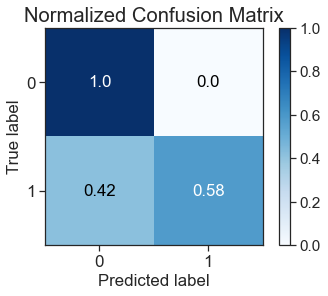

Confusion Matrix for ['Optimized Logistic Regression']


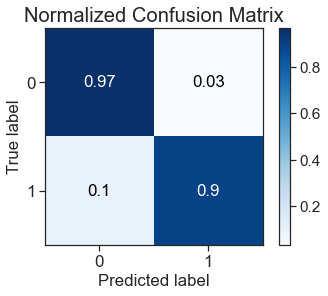

Confusion Matrix for ['Naive Bayes']


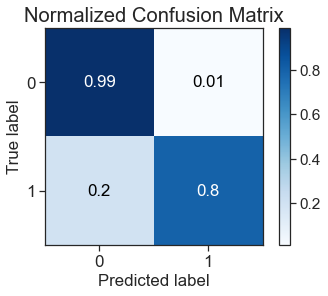

In [35]:
print("Confusion Matrix for", lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test, lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", opt_lr_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, opt_lr_predicted_labels, normalize=True)
plt.show()

print("Confusion Matrix for", nb_classifier_name)
skplt.metrics.plot_confusion_matrix(y_test_clean, nb_predicted_labels, normalize=True)
plt.show()

The optimized logistic regression model had performed well with a decrease in the Type 2 Error: False Negatives (predicted non-fraudulent but actually a fraudulent transaction). A remarkable decrease of 74% was obtained from a score of 0.38 to 0.1, when comparing the results for the optimized logistic regression model against its baseline model.


However, the Type 1 Error: False Positives (predicted fraudulent but actually a non-fraudulent transaction) had increased by 2%, from 0 to 0.02, by comparing the optimized logistic regression with its baseline model.


Overall, the impact of having more false positives was mitigated with a notable decrease in false negatives. This is important in a credit card fraud prediction scenario where the risk of misidentifying a non-fraudulent transaction outweighs the potential of missing out genuine fraudulent transactions.


With a good outcome of the test values predicted classes as compared to their actual classes, the normalized confusion matrix results for the optimized logistic regression model had outperformed the other models.

#### 3. Precision-Recall Curve

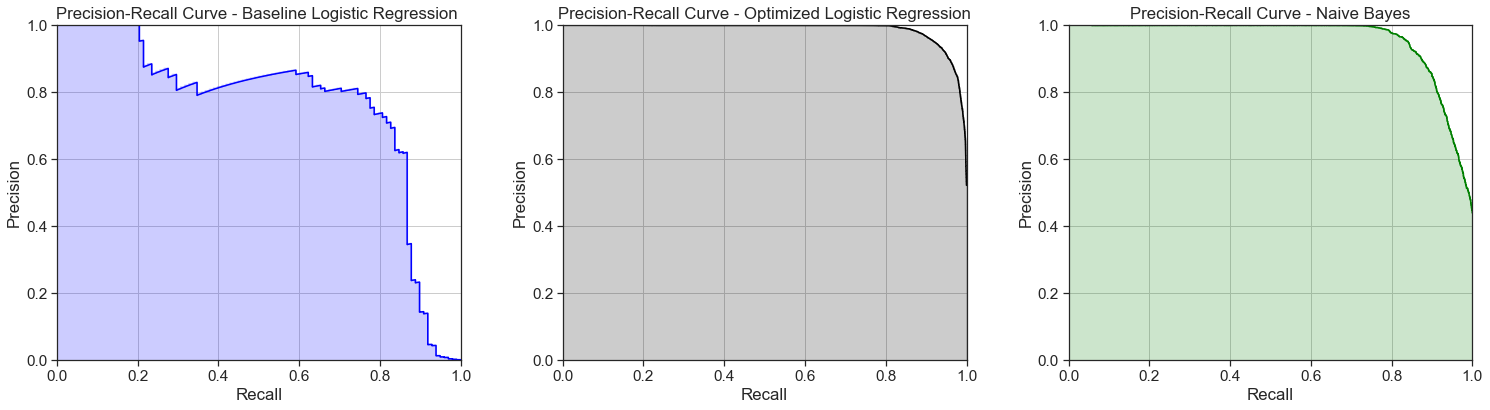

In [36]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the Precision-Recall curve for Baseline Logistic Regression  
ax = axList[0]
lr_predicted_proba = lr.predict_proba(X_test)
precision, recall, _ = precision_recall_curve(y_test, lr_predicted_proba[:,1])
ax.plot(recall, precision,color='blue')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Baseline Logistic Regression ')
ax.step(recall, precision, color='blue', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='blue')
ax.grid(True)

# Plot the Precision-Recall curve for Optimized Logistic Regression
ax = axList[1]
opt_lr_predicted_proba = opt_lr.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, opt_lr_predicted_proba[:,1])
ax.plot(recall, precision,color='black')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Optimized Logistic Regression')
ax.step(recall, precision, color='black', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='black')
ax.grid(True)

# Plot the Precision-Recall curve for Naive Bayes
ax = axList[2]
nb_predicted_proba = nb.predict_proba(X_test_clean)
precision, recall, _ = precision_recall_curve(y_test_clean, nb_predicted_proba[:,1])
ax.plot(recall, precision,color='green')
ax.set(xlabel='Recall', ylabel='Precision', xlim=[0, 1], ylim=[0, 1],
       title='Precision-Recall Curve - Naive Bayes')
ax.step(recall, precision, color='green', alpha=0.2, where='post')
ax.fill_between(recall, precision, step='post', alpha=0.2, color='green')
ax.grid(True)
plt.tight_layout()

The optimized logistic regression model had achieved a higher area under the precision-recall curve. This represents high recall and precision scores, where high precision relates to a low false-positive rate, and a high recall relates to a low false-negative rate. High scores in both showed that the optimized logistic regression model had returned accurate results (high precision), as well as a majority of all positive results (high recall).

#### 4. ROC Curve and AUC

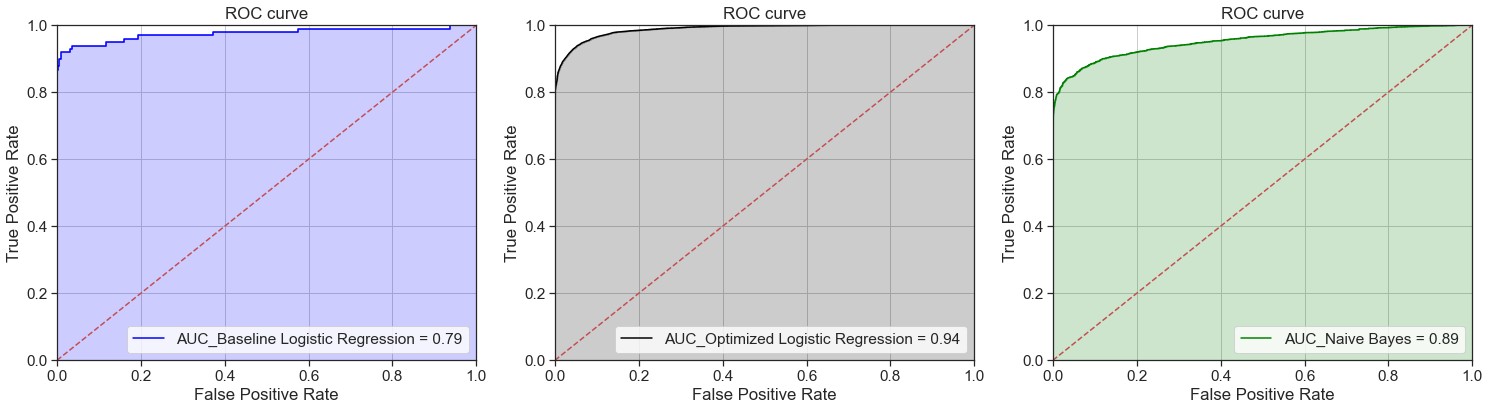

In [37]:
fig, axList = plt.subplots(ncols=3)
fig.set_size_inches(21,6)

# Plot the ROC-AUC curve for Baseline Logistic Regression
ax = axList[0]
lr = lr.fit(X_train, y_train.values.ravel()) 
lr_predicted_label_r = lr.predict_proba(X_test)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test, lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'blue', label = 'AUC_Baseline Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='blue', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='blue')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve')       
    
plot_auc(y_test, lr_predicted_label_r)
ax.grid(True)

# Plot the ROC-AUC curve for Optimized Logistic Regression
ax = axList[1]
opt_lr = opt_lr.fit(X_train_clean, y_train_clean.values.ravel()) 
opt_lr_predicted_label_r = opt_lr.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, opt_lr_predicted_labels)
    ax.plot(fpr, tpr, color = 'black', label = 'AUC_Optimized Logistic Regression = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='black', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='black')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test_clean, opt_lr_predicted_label_r);
ax.grid(True)

# Plot the ROC-AUC curve for Naive Bayes
ax = axList[2]
nb = nb.fit(X_train_clean, y_train_clean.values.ravel()) 
nb_predicted_label_r = nb.predict_proba(X_test_clean)

def plot_auc(y, probs):
    fpr, tpr, threshold = roc_curve(y, probs[:,1])
    auc = roc_auc_score(y_test_clean, nb_predicted_labels)
    ax.plot(fpr, tpr, color = 'green', label = 'AUC_Naive Bayes = %0.2f' % auc)
    ax.plot([0, 1], [0, 1],'r--')
    ax.legend(loc = 'lower right')
    ax.step(fpr, tpr, color='green', alpha=0.2, where='post')
    ax.fill_between(fpr, tpr, step='post', alpha=0.2, color='green')
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           xlim=[0, 1], ylim=[0, 1],
           title='ROC curve') 
    
plot_auc(y_test_clean, nb_predicted_label_r);
ax.grid(True)
plt.tight_layout()

All the models had outperformed the baseline guess with the optimized logistic regression model achieving the best AUC results. Thus, indicating that the optimized logistic regression model is a better classifier.

## Conclusion

The optimized logistic regression model had a better generalization performance on the testing set with reduced variance as compared to the other models. While the baseline logistic regression had over-fitted, the naïve bayes model was unable to achieve higher scores in the classification report and normalized confusion matrix, as compared to the optimized logistic regression model.

The use of optimization for logistic regression had a significant impact on the results with the following two factors being considered:

1. SMOTE to create new synthetic points in order to have a balanced dataset
2. Grid search to select the best hyper-parameters to maximize model performance

Nonetheless, the results were also attributed by the unique strength of logistic regression, where it is intended for binary (two-class) classification problems. It predicts the probability of an instance belonging to the default class, which can be derived as a binary output variable (ie. 0 or 1 classification). By optimizing the logistic regression model, it results in an even better model suited for classification problems.

To further enhance the model performance, improvements can be made where the optimized logistic regression model is trained with a large and general enough dataset instead of just 2 days’ worth of transactions.